# IoT Traffic Diversity Notebook

Point `DATA_DIR` at the folder that contains your per‑day CSVs.
The notebook will

1. Load every CSV (optionally recursive)
2. Build cumulative statistics as each file is added
3. Show how diversity (unique `(src,dst)` pairs, classifications, protocols)
   grows with more days of traffic
4. Plot helpful bar/line charts

Run the cells in order or execute the whole notebook.

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from itertools import accumulate

DATA_DIR = Path("../data/processed")  # <- change if your location is different
RECURSIVE = True                   # set False if flat directory

#### 1  Collect all CSV files

In [4]:
pattern = "**/*.csv" if RECURSIVE else "*.csv"
csv_files = sorted(DATA_DIR.glob(pattern))
print(f"Found {len(csv_files)} CSV files")

Found 9 CSV files


#### 2  Load each file and compute per‑file stats

In [5]:
per_file_stats = []
for f in csv_files:
    df = pd.read_csv(f)
    stats = {
        "file": f.relative_to(DATA_DIR),
        "packets": len(df),
        "unique_pairs": df[["src", "dst"]].drop_duplicates().shape[0],
        "unique_class": df["classfication"].nunique(),
        "unique_proto": df["protocl"].nunique(),
    }
    per_file_stats.append(stats)

stats_df = pd.DataFrame(per_file_stats)
stats_df

,file,packets,unique_pairs,unique_class,unique_proto
0,16-09-23\16-09-23.csv,947072,27824,18,7
1,16-09-24\16-09-24.csv,799235,18587,17,5
2,16-09-25\16-09-25.csv,537650,16359,17,5
3,16-09-26\16-09-26.csv,573848,19850,17,5
4,16-09-27\16-09-27.csv,527035,14889,17,5
5,16-09-28\16-09-28.csv,2019000,180877,21,6
6,16-09-29\16-09-29.csv,738906,29700,20,6
7,16-09-30\16-09-30.csv,802226,25366,20,5
8,16-10-01\16-10-01.csv,736136,30733,20,5


#### 3  Cumulative diversity growth

In [6]:
stats_df["cum_packets"] = list(accumulate(stats_df["packets"]))
stats_df["cum_pairs"]   = list(accumulate(stats_df["unique_pairs"]))
stats_df["cum_class"]   = list(accumulate(stats_df["unique_class"]))
stats_df["cum_proto"]   = list(accumulate(stats_df["unique_proto"]))
stats_df

,file,packets,unique_pairs,unique_class,unique_proto,cum_packets,cum_pairs,cum_class,cum_proto
0,16-09-23\16-09-23.csv,947072,27824,18,7,947072,27824,18,7
1,16-09-24\16-09-24.csv,799235,18587,17,5,1746307,46411,35,12
2,16-09-25\16-09-25.csv,537650,16359,17,5,2283957,62770,52,17
3,16-09-26\16-09-26.csv,573848,19850,17,5,2857805,82620,69,22
4,16-09-27\16-09-27.csv,527035,14889,17,5,3384840,97509,86,27
5,16-09-28\16-09-28.csv,2019000,180877,21,6,5403840,278386,107,33
6,16-09-29\16-09-29.csv,738906,29700,20,6,6142746,308086,127,39
7,16-09-30\16-09-30.csv,802226,25366,20,5,6944972,333452,147,44
8,16-10-01\16-10-01.csv,736136,30733,20,5,7681108,364185,167,49


#### 4  Plots

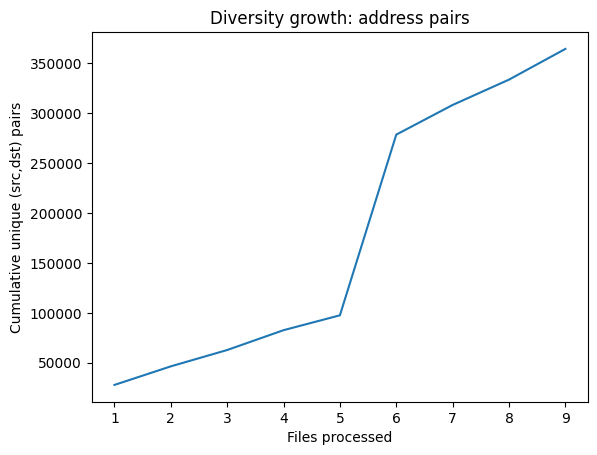

In [7]:
plt.figure()
plt.plot(stats_df.index + 1, stats_df["cum_pairs"])
plt.xlabel("Files processed")
plt.ylabel("Cumulative unique (src,dst) pairs")
plt.title("Diversity growth: address pairs")
plt.show()

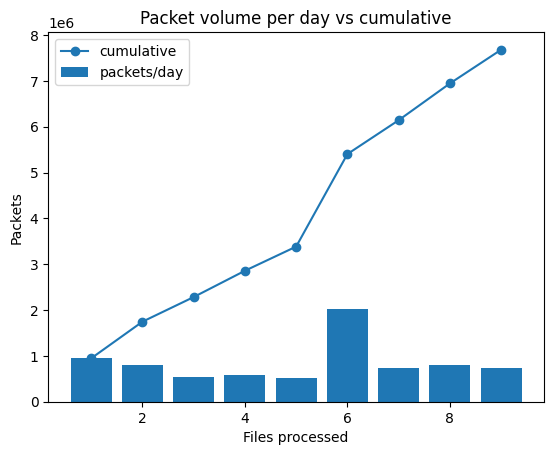

In [8]:
plt.figure()
plt.bar(stats_df.index + 1, stats_df["packets"], label="packets/day")
plt.plot(stats_df.index + 1, stats_df["cum_packets"], marker="o", label="cumulative")
plt.xlabel("Files processed")
plt.ylabel("Packets")
plt.title("Packet volume per day vs cumulative")
plt.legend()
plt.show()

Loaded 7,681,108 packets from 9 files


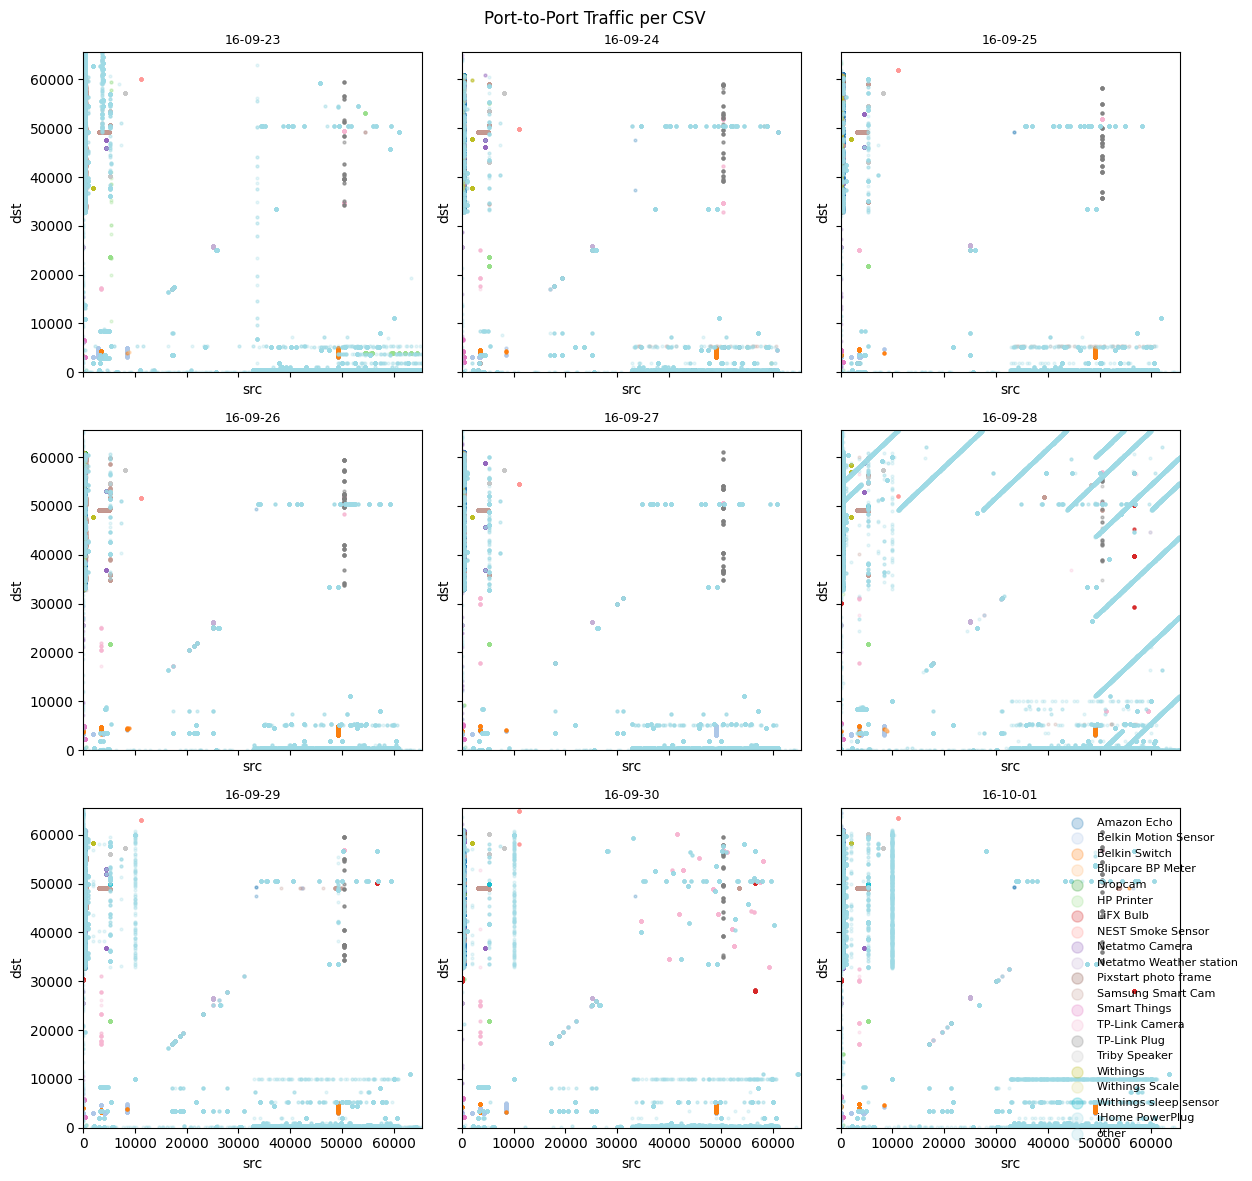

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

CSV_ROOT = Path("../data/processed")
dfs      = []

for csv in sorted(CSV_ROOT.rglob("*.csv")):
    df = pd.read_csv(
        csv,
        dtype={"protocl": "uint16", "src": "uint16", "dst": "uint16",
               "classfication": "category"},
        engine="pyarrow"  # fast if available; falls back otherwise
    )
    df.rename(columns={"protocl": "protocol",
                       "classfication": "classification"}, inplace=True)
    df["source"] = csv.relative_to(CSV_ROOT).as_posix()   # tag the rows
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(df_all):,} packets from {len(dfs)} files")

# %% Build a consistent colour map -------------------------------------------
df_all = pd.concat(dfs, ignore_index=True)

# make sure it's categorical
df_all["classification"] = df_all["classification"].astype("category")

classes = df_all["classification"].cat.categories

cmap    = {c: plt.cm.tab20(i) for i, c in enumerate(classes)}

# %% One figure per CSV -------------------------------------------------------
n       = len(dfs)
cols    = 3                                    # plots per row
rows    = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols,
                         figsize=(cols * 4, rows * 4),
                         sharex=True, sharey=True)
axes    = axes.flatten()

for ax, (csv, df) in zip(axes, zip(sorted(CSV_ROOT.rglob("*.csv")), dfs)):
    # sample up to 200 k rows for speed
    df_plot = df if len(df) <= 200_000 else df.sample(200_000, random_state=0)

    for c in classes:
        sub = df_plot[df_plot["classification"] == c]
        ax.scatter(sub["src"], sub["dst"],
                   s=4, alpha=0.25, color=cmap[c])

    ax.set_title(csv.stem, fontsize=9)
    ax.set_xlim(0, 65535); ax.set_ylim(0, 65535)
    ax.set_xlabel("src"); ax.set_ylabel("dst")


# hide empty axes if any
for ax in axes[n:]:
    ax.axis("off")

fig.suptitle("Port-to-Port Traffic per CSV")
fig.tight_layout()
plt.legend(classes, loc="upper right", markerscale=4, fontsize=8,
           frameon=False, bbox_to_anchor=(1.2, 1.0))